<a href="https://colab.research.google.com/github/alanfuentes92/business_analytics/blob/main/Fuentes_Alan-Comisi%C3%B3n_25262-TPI_Data_Analytics-Entrega_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1: Recopilación y Preparación de Datos
---

In [ ]:
# Configuración de librerías y descarga de datasets
!pip -q install gdown

import pandas as pd
import gdown
from pathlib import Path

# IDs de archivos
FILE_IDS = {
    "marketing": "1ZSfAcNDyo2eiioc7za_h57lvlm2RtScu",  # marketing.csv
    "clientes":  "11-FPOE9X1AvxGE6AUXTCspVQJzrLT_2f",  # clientes.csv
    "ventas":    "1jlo-TjeDEkIeHrbcdSVXO8pqzTTfyE6N",  # ventas.csv
}

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Descarga
for name, fid in FILE_IDS.items():
    url = f"https://drive.google.com/uc?id={fid}"
    out = DATA_DIR / f"{name}.csv"
    gdown.download(url=url, output=str(out), quiet=False)

print("Descarga completada. Archivos en:", DATA_DIR)

Downloading...
From: https://drive.google.com/uc?id=1ZSfAcNDyo2eiioc7za_h57lvlm2RtScu
To: /content/data/marketing.csv
100%|██████████| 4.46k/4.46k [00:00<00:00, 12.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11-FPOE9X1AvxGE6AUXTCspVQJzrLT_2f
To: /content/data/clientes.csv
100%|██████████| 24.2k/24.2k [00:00<00:00, 14.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jlo-TjeDEkIeHrbcdSVXO8pqzTTfyE6N
To: /content/data/ventas.csv
100%|██████████| 166k/166k [00:00<00:00, 60.6MB/s]

Descarga completada. Archivos en: /content/data


In [ ]:
# 1. Carga de datos a DataFrames ===
# Carga desde los CSV descargados
df_marketing = pd.read_csv("/content/data/marketing.csv")
df_clientes  = pd.read_csv("/content/data/clientes.csv")
df_ventas    = pd.read_csv("/content/data/ventas.csv")

# Verificación de estructura
print("marketing:", df_marketing.shape, df_marketing.columns.tolist())
print("clientes :", df_clientes.shape,  df_clientes.columns.tolist())
print("ventas   :", df_ventas.shape,    df_ventas.columns.tolist())

display(df_marketing.head(3))
display(df_clientes.head(3))
display(df_ventas.head(3))

marketing: (90, 6) ['id_campanha', 'producto', 'canal', 'costo', 'fecha_inicio', 'fecha_fin']
clientes : (567, 5) ['id_cliente', 'nombre', 'edad', 'ciudad', 'ingresos']
ventas   : (3035, 6) ['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta', 'categoria']


,id_campanha,producto,canal,costo,fecha_inicio,fecha_fin
0,74,Adorno de pared,TV,4.81,20/03/2024,03/05/2024
1,12,Tablet,RRSS,3.40,26/03/2024,13/05/2024
2,32,Lámpara de mesa,Email,5.54,28/03/2024,20/04/2024


,id_cliente,nombre,edad,ciudad,ingresos
0,1,Aloysia Screase,44,Mar del Plata,42294.68
1,2,Kristina Scaplehorn,25,Posadas,24735.04
2,3,Filip Castagne,50,Resistencia,35744.85


,id_venta,producto,precio,cantidad,fecha_venta,categoria
0,792,Cuadro decorativo,$69.94,5.0,02/01/2024,Decoración
1,811,Lámpara de mesa,$105.10,5.0,02/01/2024,Decoración
2,1156,Secadora,$97.96,3.0,02/01/2024,Electrodomésticos


In [ ]:
# Normalización de columnas numéricas y fechas

import re

def normalize_number(x):
    """
    Se convierten string a float.
    Devuelve <NA> si no se puede.
    """
    if pd.isna(x):
        return pd.NA
    s = str(x).strip()
    s = re.sub(r'[^\d,.\-]', '', s)
    if s in ("", ".", ",", "-", "+", "--"):
        return pd.NA

    if "," in s and "." in s:
        if s.rfind(",") > s.rfind("."):
            s = s.replace(".", "")
            s = s.replace(",", ".")
        else:
            s = s.replace(",", "")
    else:
        if "," in s:
            s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return pd.NA

# Conversión en df_ventas
for col in ("precio", "cantidad"):
    if col not in df_ventas.columns:
        raise KeyError(f"Falta columna '{col}' en df_ventas. Columnas: {df_ventas.columns.tolist()}")
    df_ventas[col] = df_ventas[col].apply(normalize_number).astype("Float64")

# Fechas
df_ventas["fecha_venta"] = pd.to_datetime(df_ventas["fecha_venta"], errors="coerce", dayfirst=True)

# Reporte
print("Nulos post-normalización -> precio:", int(df_ventas["precio"].isna().sum()),
      "| cantidad:", int(df_ventas["cantidad"].isna().sum()),
      "| fecha_venta:", int(df_ventas["fecha_venta"].isna().sum()))

display(df_ventas.head(3))

Nulos post-normalización -> precio: 2 | cantidad: 2 | fecha_venta: 0


,id_venta,producto,precio,cantidad,fecha_venta,categoria
0,792,Cuadro decorativo,69.94,5.0,2024-01-02,Decoración
1,811,Lámpara de mesa,105.1,5.0,2024-01-02,Decoración
2,1156,Secadora,97.96,3.0,2024-01-02,Electrodomésticos


In [ ]:
# 2. Cálculo de ventas mensuales
# Variables base por fila
df_ventas["total"] = df_ventas["precio"] * df_ventas["cantidad"]

# Filtro para evitar nulos
df_ventas_clean = df_ventas.dropna(subset=["total", "fecha_venta"]).copy()

# Agrupación por mes
ventas_mensuales = (
    df_ventas_clean
      .groupby(df_ventas_clean["fecha_venta"].dt.to_period("M"))["total"]
      .sum()
      .reset_index()
      .rename(columns={"fecha_venta": "Mes", "total": "Total_Ventas"})
)
ventas_mensuales["Mes"] = ventas_mensuales["Mes"].astype(str)

print("Ventas mensuales (Total_Ventas):")
display(ventas_mensuales)

Ventas mensuales (Total_Ventas):


,Mes,Total_Ventas
0,2024-01,129604.99
1,2024-02,118672.44
2,2024-03,136779.15
3,2024-04,144380.1
4,2024-05,143727.25
5,2024-06,108480.17
6,2024-07,116229.97
7,2024-08,119680.15
8,2024-09,115787.85
9,2024-10,112117.13


In [ ]:
# 3. Estructuras de Datos para ventas
# Lista de diccionarios

ventas_ejemplo = [
    {"producto": "Notebook", "precio": 1500.0, "cantidad": 2},
    {"producto": "Mouse",    "precio":   20.0, "cantidad": 5},
    {"producto": "Teclado",  "precio":   50.0, "cantidad": 3},
]

# Cálculos de totales por registro
for v in ventas_ejemplo:
    v["total"] = v["precio"] * v["cantidad"]

# Transformación a DataFrame
df_ventas_ejemplo = pd.DataFrame(ventas_ejemplo)
display(df_ventas_ejemplo)

,producto,precio,cantidad,total
0,Notebook,1500.0,2,3000.0
1,Mouse,20.0,5,100.0
2,Teclado,50.0,3,150.0


In [ ]:
# 4. Análisis exploratorio inicial con Pandas
def eda_basico(nombre, df):
    print(f"\n=== {nombre.upper()} ===")
    print("Shape:", df.shape)
    print("\nTipos de datos:")
    print(df.dtypes)
    print("\nEstadísticas numéricas:")
    display(df.describe(include="number"))
    print("\nPrimeras filas:")
    display(df.head(5))

eda_basico("marketing", df_marketing)
eda_basico("clientes",  df_clientes)
eda_basico("ventas",    df_ventas)

# Ejemplo: Perfiles de cardinalidad en columnas clave
print("\nCardinalidad en columnas relevantes:")
if "producto" in df_ventas.columns:
    print("Ventas.producto ->", df_ventas["producto"].nunique(), "valores únicos")
if "categoria" in df_ventas.columns:
    print("Ventas.categoria ->", df_ventas["categoria"].nunique(), "valores únicos")
if "canal" in df_marketing.columns:
    print("Marketing.canal ->", df_marketing["canal"].nunique(), "valores únicos")
if "ciudad" in df_clientes.columns:
    print("Clientes.ciudad ->", df_clientes["ciudad"].nunique(), "valores únicos")


=== MARKETING ===
Shape: (90, 6)

Tipos de datos:
id_campanha       int64
producto         object
canal            object
costo           float64
fecha_inicio     object
fecha_fin        object
dtype: object

Estadísticas numéricas:


,id_campanha,costo
count,90.000000,90.000000
mean,45.500000,4.928667
std,26.124701,0.947750
min,1.000000,2.950000
25%,23.250000,4.372500
50%,45.500000,4.900000
75%,67.750000,5.562500
max,90.000000,7.390000



Primeras filas:


,id_campanha,producto,canal,costo,fecha_inicio,fecha_fin
0,74,Adorno de pared,TV,4.81,20/03/2024,03/05/2024
1,12,Tablet,RRSS,3.40,26/03/2024,13/05/2024
2,32,Lámpara de mesa,Email,5.54,28/03/2024,20/04/2024
3,21,Smartphone,RRSS,6.37,29/03/2024,16/05/2024
4,58,Alfombra,Email,4.25,31/03/2024,05/05/2024



=== CLIENTES ===
Shape: (567, 5)

Tipos de datos:
id_cliente      int64
nombre         object
edad            int64
ciudad         object
ingresos      float64
dtype: object

Estadísticas numéricas:


,id_cliente,edad,ingresos
count,567.000000,567.000000,567.000000
mean,284.000000,37.940035,34668.739012
std,163.823075,10.202885,12974.531446
min,1.000000,20.000000,170.290000
25%,142.500000,30.000000,26015.240000
50%,284.000000,37.000000,35066.830000
75%,425.500000,43.000000,42457.100000
max,567.000000,81.000000,88053.010000



Primeras filas:


,id_cliente,nombre,edad,ciudad,ingresos
0,1,Aloysia Screase,44,Mar del Plata,42294.68
1,2,Kristina Scaplehorn,25,Posadas,24735.04
2,3,Filip Castagne,50,Resistencia,35744.85
3,4,Liuka Luard,39,Bahía Blanca,27647.96
4,5,Dore Cockshtt,28,Rosario,28245.65



=== VENTAS ===
Shape: (3035, 7)

Tipos de datos:
id_venta                int64
producto               object
precio                Float64
cantidad              Float64
fecha_venta    datetime64[ns]
categoria              object
total                 Float64
dtype: object

Estadísticas numéricas:


,id_venta,precio,cantidad,total
count,3035.000000,3033.0,3033.0,3033.0
mean,1499.851400,75.289034,6.496538,488.968985
std,866.465379,28.734666,3.45725,334.594511
min,1.000000,26.0,1.0,26.3
25%,748.500000,50.02,3.0,220.5
50%,1502.000000,75.27,7.0,418.05
75%,2249.500000,100.04,9.0,708.89
max,3000.000000,124.97,12.0,1488.12



Primeras filas:


,id_venta,producto,precio,cantidad,fecha_venta,categoria,total
0,792,Cuadro decorativo,69.94,5.0,2024-01-02,Decoración,349.7
1,811,Lámpara de mesa,105.1,5.0,2024-01-02,Decoración,525.5
2,1156,Secadora,97.96,3.0,2024-01-02,Electrodomésticos,293.88
3,1372,Heladera,114.35,8.0,2024-01-02,Electrodomésticos,914.8
4,1546,Secadora,106.21,4.0,2024-01-02,Electrodomésticos,424.84



Cardinalidad en columnas relevantes:
Ventas.producto -> 30 valores únicos
Ventas.categoria -> 3 valores únicos
Marketing.canal -> 3 valores únicos
Clientes.ciudad -> 12 valores únicos


In [ ]:
# 5. Calidad de Datos
def reporte_calidad(nombre, df):
    print(f"\n=== Calidad de Datos: {nombre.upper()} ===")
    print("Nulos por columna:")
    display(df.isnull().sum().to_frame("n_nulos").T)
    print("Duplicados:", int(df.duplicated().sum()))

reporte_calidad("marketing", df_marketing)
reporte_calidad("clientes",  df_clientes)
reporte_calidad("ventas",    df_ventas)

# Muestra filas con problemas en 'ventas'
problemas_ventas = df_ventas[df_ventas[["precio","cantidad","fecha_venta"]].isna().any(axis=1)]
print("\nFilas con posibles problemas en 'ventas' (primeras 10):")
display(problemas_ventas.head(10))


=== Calidad de Datos: MARKETING ===
Nulos por columna:


,id_campanha,producto,canal,costo,fecha_inicio,fecha_fin
n_nulos,0,0,0,0,0,0


Duplicados: 0

=== Calidad de Datos: CLIENTES ===
Nulos por columna:


,id_cliente,nombre,edad,ciudad,ingresos
n_nulos,0,0,0,0,0


Duplicados: 0

=== Calidad de Datos: VENTAS ===
Nulos por columna:


,id_venta,producto,precio,cantidad,fecha_venta,categoria,total
n_nulos,0,0,2,2,0,0,2


Duplicados: 35

Filas con posibles problemas en 'ventas' (primeras 10):


,id_venta,producto,precio,cantidad,fecha_venta,categoria,total
136,627,Elementos de cerámica,<NA>,<NA>,2024-01-17,Decoración,<NA>
139,2171,Parlantes Bluetooth,<NA>,<NA>,2024-01-17,Electrónica,<NA>


# Etapa 2: Preprocesamiento y Limpieza de Datos
---

In [ ]:
# 1. Limpieza de Datos
# Eliminar duplicados, espacios y caracteres no deseados.

# Duplicados
dup_count_before = df_ventas.duplicated().sum()
df_ventas = df_ventas.drop_duplicates()
dup_count_after = df_ventas.duplicated().sum()

# Limpieza de texto
def clean_text(s):
    if isinstance(s, str):
        s = s.strip()               # elimina espacios extremos
        s = s.replace('\n', ' ')    # reemplaza saltos de línea
        s = s.replace('\t', ' ')
        return s
    return s

for df in [df_marketing, df_clientes, df_ventas]:
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].apply(clean_text)

# Eliminar caracteres no deseados
df_ventas["producto"] = df_ventas["producto"].str.replace(r"[^A-Za-z0-9áéíóúÁÉÍÓÚñÑ\s]", "", regex=True)
df_ventas["categoria"] = df_ventas["categoria"].str.replace(r"[^A-Za-z0-9áéíóúÁÉÍÓÚñÑ\s]", "", regex=True)

# Resultado
print("Duplicados eliminados:", dup_count_before - dup_count_after)
print("Filas finales en ventas:", len(df_ventas))
display(df_ventas.head(3))


Duplicados eliminados: 35
Filas finales en ventas: 3000


,id_venta,producto,precio,cantidad,fecha_venta,categoria,total
0,792,Cuadro decorativo,69.94,5.0,2024-01-02,Decoración,349.7
1,811,Lámpara de mesa,105.1,5.0,2024-01-02,Decoración,525.5
2,1156,Secadora,97.96,3.0,2024-01-02,Electrodomésticos,293.88


In [ ]:
# 2. Transformación de datos
# Obtener los productos con mayor número de ventas totales.

# Total por venta
df_ventas["total"] = df_ventas["precio"] * df_ventas["cantidad"]

# Rendimiento por producto
rendimiento = (
    df_ventas.groupby("producto")["total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Productos que están en el 20% superior por ingresos
top_threshold = rendimiento["total"].quantile(0.80)
productos_top = rendimiento[rendimiento["total"] >= top_threshold]["producto"]

# Filtrar ventas deseadas
df_ventas_top = df_ventas[df_ventas["producto"].isin(productos_top)].copy()

print(f"Productos de alto rendimiento (umbral ≥ {top_threshold:,.2f}): {len(productos_top)} encontrados")
display(rendimiento.head(10))
print("\nVista de tabla filtrada (ventas de alto rendimiento):")
display(df_ventas_top.head(5))


Productos de alto rendimiento (umbral ≥ 52,518.85): 6 encontrados


,producto,total
0,Lámpara de mesa,82276.38
1,Auriculares,74175.58
2,Microondas,72562.89
3,Cafetera,59607.31
4,Cuadro decorativo,54297.6
5,Smartphone,54132.44
6,Secadora,52115.45
7,Jarrón decorativo,51130.88
8,Batidora,50979.2
9,Rincón de plantas,50456.45



Vista de tabla filtrada (ventas de alto rendimiento):


,id_venta,producto,precio,cantidad,fecha_venta,categoria,total
0,792,Cuadro decorativo,69.94,5.0,2024-01-02,Decoración,349.7
1,811,Lámpara de mesa,105.1,5.0,2024-01-02,Decoración,525.5
19,882,Cuadro decorativo,101.92,9.0,2024-01-04,Decoración,917.28
28,2155,Auriculares,84.8,10.0,2024-01-05,Electrónica,848.0
31,1572,Cafetera,61.4,9.0,2024-01-06,Electrodomésticos,552.6


Resumen de ventas por categoría:


,categoria,ingresos_totales,ventas_totales,promedio_venta
0,Electrodomésticos,505299.63,1000,505.29963
1,Electrónica,482577.8,999,483.54489
2,Decoración,479216.09,1001,479.21609


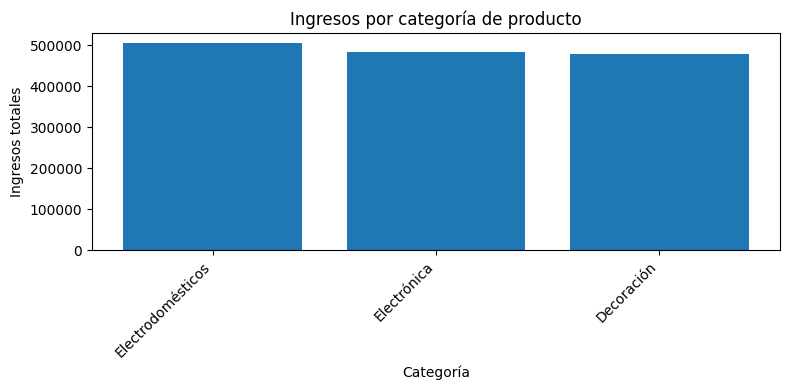

In [ ]:
# 3. Agregación por categoría
# Resumir los ingresos generados por categoría.

df_ventas["categoria"] = df_ventas["categoria"].fillna("Sin categoría")

# Total de ingresos y cantidad de transacciones por categoría.
resumen_categoria = (
    df_ventas.groupby("categoria")
    .agg(
        ingresos_totales=("total", "sum"),
        ventas_totales=("id_venta", "count"),
        promedio_venta=("total", "mean")
    )
    .sort_values("ingresos_totales", ascending=False)
    .reset_index()
)

print("Resumen de ventas por categoría:")
display(resumen_categoria)

# Gráfico de barras
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(resumen_categoria["categoria"], resumen_categoria["ingresos_totales"])
plt.title("Ingresos por categoría de producto")
plt.xlabel("Categoría")
plt.ylabel("Ingresos totales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# 4. Integración de Datos (ventas + marketing)
# Unir los datasets para obtener una visión completa.

# Simplificar columnas
ventas_base = df_ventas[["producto", "fecha_venta", "categoria", "total"]].copy()
marketing_base = df_marketing[["producto", "canal", "costo", "fecha_inicio", "fecha_fin"]].copy()

# Convertir fechas a datetime
for col in ["fecha_inicio", "fecha_fin"]:
    marketing_base[col] = pd.to_datetime(marketing_base[col], errors="coerce", dayfirst=True)

# Integramos por 'producto'
df_integrado = pd.merge(
    ventas_base,
    marketing_base,
    on="producto",
    how="left"
)

# Resultado
print("Integración completada. Filas:", len(df_integrado))
display(df_integrado.head(10))

# Calculamos ingresos totales por canal de marketing
ingresos_por_canal = (
    df_integrado.groupby("canal")["total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
print("\nIngresos totales por canal de marketing:")
display(ingresos_por_canal)

Integración completada. Filas: 9000


,producto,fecha_venta,categoria,total,canal,costo,fecha_inicio,fecha_fin
0,Cuadro decorativo,2024-01-02,Decoración,349.7,RRSS,5.27,2024-04-27,2024-06-04
1,Cuadro decorativo,2024-01-02,Decoración,349.7,Email,5.28,2024-08-15,2024-09-12
2,Cuadro decorativo,2024-01-02,Decoración,349.7,TV,5.30,2024-11-05,2024-12-23
3,Lámpara de mesa,2024-01-02,Decoración,525.5,Email,5.54,2024-03-28,2024-04-20
4,Lámpara de mesa,2024-01-02,Decoración,525.5,RRSS,5.88,2024-05-30,2024-06-29
5,Lámpara de mesa,2024-01-02,Decoración,525.5,TV,4.51,2024-08-26,2024-10-07
6,Secadora,2024-01-02,Electrodomésticos,293.88,RRSS,5.10,2024-07-24,2024-08-30
7,Secadora,2024-01-02,Electrodomésticos,293.88,TV,5.69,2024-11-03,2024-11-28
8,Secadora,2024-01-02,Electrodomésticos,293.88,Email,3.80,2024-12-20,2025-01-07
9,Heladera,2024-01-02,Electrodomésticos,914.8,Email,4.20,2024-05-06,2024-07-05



Ingresos totales por canal de marketing:


,canal,total
0,Email,1467093.52
1,RRSS,1467093.52
2,TV,1467093.52
